# Vertical Profile

This document shows how to use the [/trajectory/profile endpoint](https://api.contrails.org/openapi#/Trajectory/vertical_trajectory_profile_v0_trajectory_profile_post) (added in version 0.12.0) to visualize CoCiP over a vertical profile of a trajectory.

The predictions provided in the response contain elements of both the [CoCiP trajectory model](https://apidocs.contrails.org/notebooks/get_started.html#CoCiP) and the [Gridded CoCiP model](https://apidocs.contrails.org/notebooks/get_started.html#id2). In particular, this endpoint computes a 2D grid of predictions parameterized by the altitude and time of the trajectory. The longitude, latitude, and azimuth used to construct this grid are taken from the trajectory itself. Aircraft performance variables are assumed to be nominal (the aircraft is always assumed to be in a cruise state for the gridded model). There are [notable differences between the trajectory and grid models](https://apidocs.contrails.org/notebooks/comparison.html) that are important to understand.

In [1]:
import os

import matplotlib.pyplot as plt  # pip install matplotlib
import numpy as np  # pip install numpy
import pandas as pd  # pip install pandas
import requests  # pip install requests

In [2]:
# Define credentials
URL = "https://api.contrails.org"
api_key = os.environ["CONTRAILS_API_KEY"]  # put in your API key here
headers = {"x-api-key": api_key}

## Create a synthetic flight trajectory

The cell below follows the same recipe used in [Get Started](https://apidocs.contrails.org/notebooks/get_started.html#Trajectory-API) and [Customizing Requests](https://apidocs.contrails.org/notebooks/customization.html#Create-flight) for creating a synthetic flight. In particular, the flight below is not meant to be realistic; it only serves as an example. The trajectory itself was cherry-picked to fly through regions of potential contrail formation according to CoCiP.

In [3]:
n_waypoints = 300

t0 = "2023-01-16T09:00:00"
t1 = "2023-01-16T14:00:00"
time = pd.date_range(t0, t1, periods=n_waypoints)

# fmt: off
altitude = np.r_[
    np.linspace(10000, 30000, 30),   # Climb to 30000 ft
    [30000 for _ in range(40)],      # Cruise at 30000 ft
    [31000, 32000],                  # Climb to 32000 ft
    [32000 for _ in range(50)],      # Cruise at 32000 ft
    [33000, 34000, 35000, 36000],    # Climb to 36000 ft
    [36000 for _ in range(60)],      # Cruise at 36000 ft
    [37000, 38000, 39000, 40000],    # Climb to 40000 ft
    [40000 for _ in range(80)],      # Cruise at 40000 ft
    np.linspace(40000, 10000, 30),   # Descend to 10000 ft
]
# fmt: on

flight = {
    "longitude": np.linspace(-10, -60, n_waypoints).tolist(),
    "latitude": np.linspace(45, 40, n_waypoints).tolist(),
    "altitude": altitude.tolist(),
    "time": time.astype(int).tolist(),
    "aircraft_type": "A320",
}

## Make the request

Expect requests to the `/trajectory/profile` endpoint to take 1 - 2 minutes to complete. For faster but less precise predictions, set `mode=grid` on the request body to approximate CoCiP predictions using a pre-computed gridded model (the same data served in `/grid/cocip`). This "grid" mode of computation is not available for all trajectories and is not demonstrated in this notebook.

In [4]:
endpoint = f"{URL}/v0/trajectory/profile"

r = requests.post(endpoint, json=flight, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
print(f"Response content-type: {r.headers['content-type']}")

HTTP Response Code: 200 OK
Response content-type: application/json


## Working with the response

The `profile` field contains the predictions for the vertical profile of the trajectory.

> The `profile` predictions are expressed in **energy forcing per meter of flight trajectory [J / m]**. The underlying model assumes the aircraft is in a nominal state. See the [comparison document](https://apidocs.contrails.org/notebooks/comparison.html), which discusses the differences between the trajectory and grid models. Here, the `profile` predictions behave like the grid model.

### Extract as `numpy` arrays

The JSON response can easily be converted to [numpy](https://numpy.org/) arrays.

In [5]:
r_json = r.json()

profile = r_json["profile"]
profile_fls = np.array([p["flight_level"] for p in profile])
ef_arr = np.array([p["ef_per_m"] for p in profile])

### Converting to `pandas` or `xarray`

The data can also be converted to [pandas](https://pandas.pydata.org/) or [xarray](https://docs.xarray.dev/en/stable/) data structures.

In [6]:
df = pd.DataFrame(ef_arr.T, index=time, columns=profile_fls)
df = df.rename_axis("time", axis=0).rename_axis("flight_level", axis=1)
df.head()

flight_level                   270  280  290  300          310          320  \
time                                                                          
2023-01-16 09:00:00.000000000  0.0  0.0  0.0  0.0  182300000.0  101400000.0   
2023-01-16 09:01:00.200668896  0.0  0.0  0.0  0.0  177900000.0  110900000.0   
2023-01-16 09:02:00.401337792  0.0  0.0  0.0  0.0  166100000.0  105500000.0   
2023-01-16 09:03:00.602006688  0.0  0.0  0.0  0.0  184000000.0   99800000.0   
2023-01-16 09:04:00.802675585  0.0  0.0  0.0  0.0  182500000.0  118500000.0   

flight_level                   330  340  350  360  370  380  390  400  410  \
time                                                                         
2023-01-16 09:00:00.000000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-16 09:01:00.200668896  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-16 09:02:00.401337792  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-16 09:03:00.602006688  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-16 09:04:00.802675585  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

flight_level                   420  430  440  
time                                          
2023-01-16 09:00:00.000000000  0.0  0.0  0.0  
2023-01-16 09:01:00.200668896  0.0  0.0  0.0  
2023-01-16 09:02:00.401337792  0.0  0.0  0.0  
2023-01-16 09:03:00.602006688  0.0  0.0  0.0  
2023-01-16 09:04:00.802675585  0.0  0.0  0.0

In [7]:
da = df.unstack().to_xarray()

# Fill in some metadata (this is optional)
da.attrs = {"long_name": "Energy forcing per meter of flight trajectory", "units": "J / m"}
da["flight_level"].attrs = {"long_name": "Flight level", "units": "hectofeet"}
da["time"].attrs = {"long_name": "Time", "units": "UTC"}

print(da)

<xarray.DataArray (flight_level: 18, time: 300)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * flight_level  (flight_level) int64 270 280 290 300 310 ... 410 420 430 440
  * time          (time) datetime64[ns] 2023-01-16T09:00:00 ... 2023-01-16T14...
Attributes:
    long_name:  Energy forcing per meter of flight trajectory
    units:      J / m


## Visualize

### Visualize profile predictions

We use `xarray` as a convenience to visualize the data.

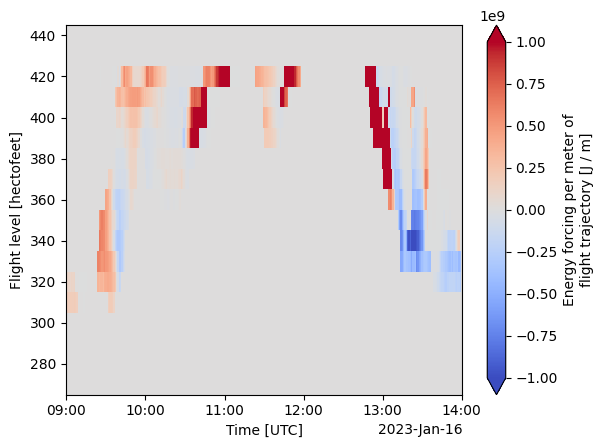

In [8]:
da.plot(vmin=-1e9, vmax=1e9, cmap="coolwarm");

### View the trajectory within the profile grid

In [9]:
da["altitude"] = da["flight_level"] * 100.0
da = da.swap_dims(flight_level="altitude")
da["altitude"].attrs = {"long_name": "Altitude", "units": "feet"}

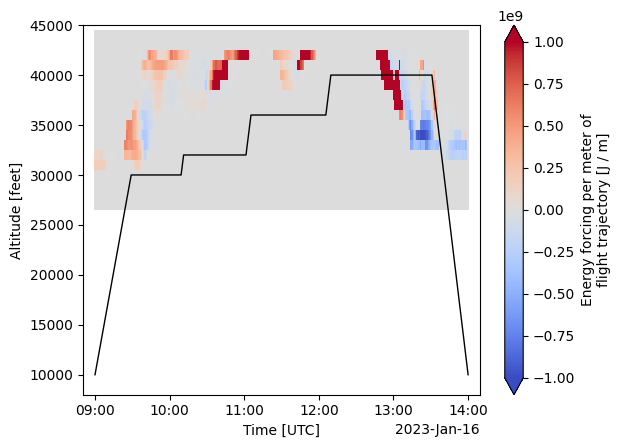

In [10]:
fig, ax = plt.subplots()
da.plot(vmin=-1e9, vmax=1e9, cmap="coolwarm", ax=ax)

ax.set_ylim(8000, 45000)
x0, x1 = ax.get_xlim()
ax.set_xlim(x0 - 0.03 * (x1 - x0), x1 + 0.03 * (x1 - x0))

ax.plot(time, altitude, color="black", lw=1);

### Request the plot directly through the API

By including a `format="png"` key-value pair in the request body, the API will return a static plot as a PNG image. (The API backend implementation is identical to what is used in this notebook.) You won't be able to customize this plot, but it is a convenient way to see the predictions without writing any code.

In [11]:
r = requests.post(endpoint, json=flight | {"format": "png"}, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
print(f"Response content-type: {r.headers['content-type']}")

HTTP Response Code: 200 OK
Response content-type: image/png


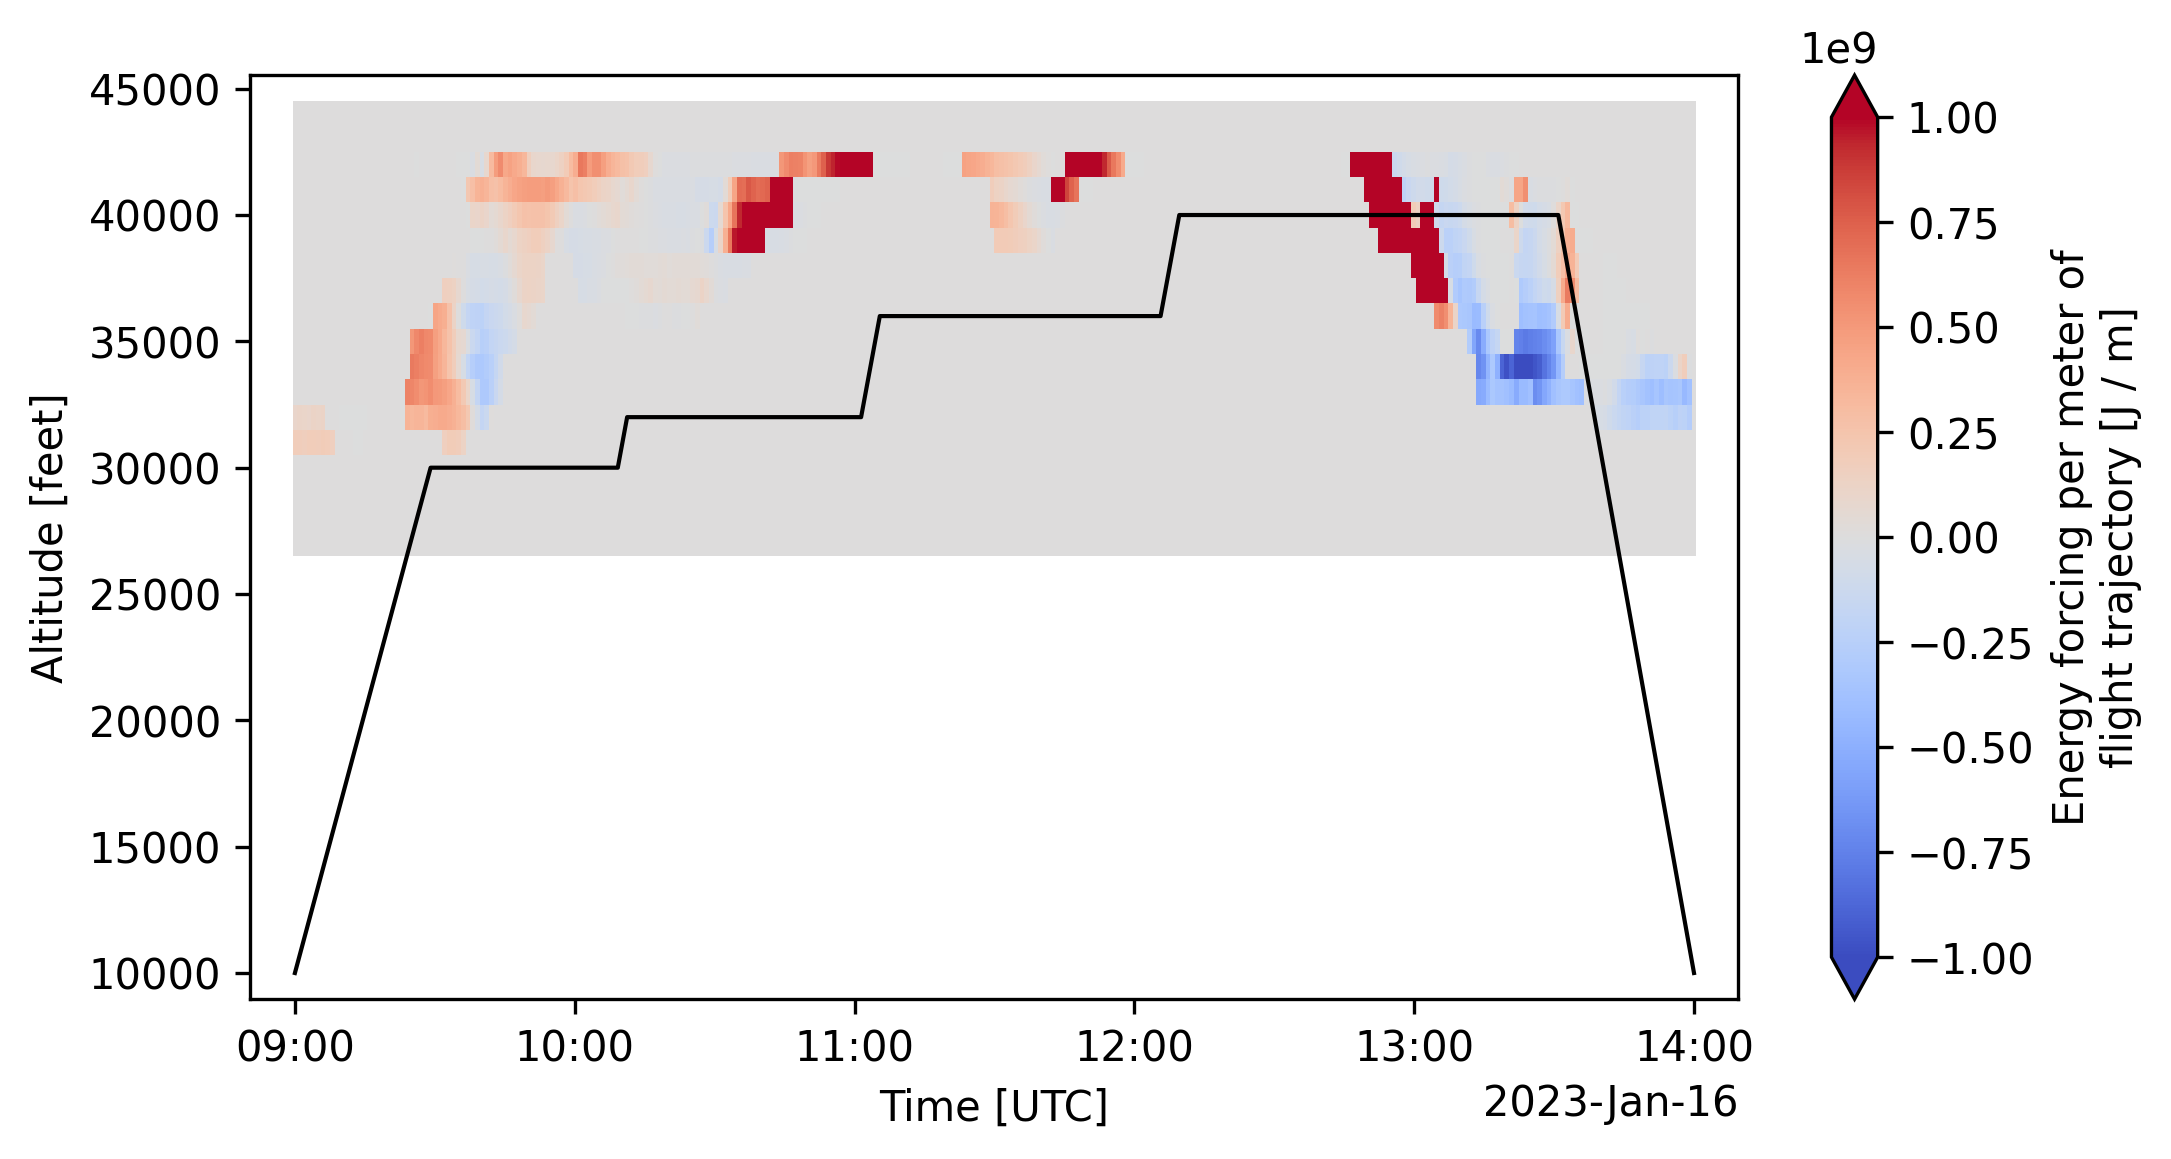

In [12]:
# Display in the notebook
from IPython.display import Image

display(Image(data=r.content, format="png"))